## ПЗ 2

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


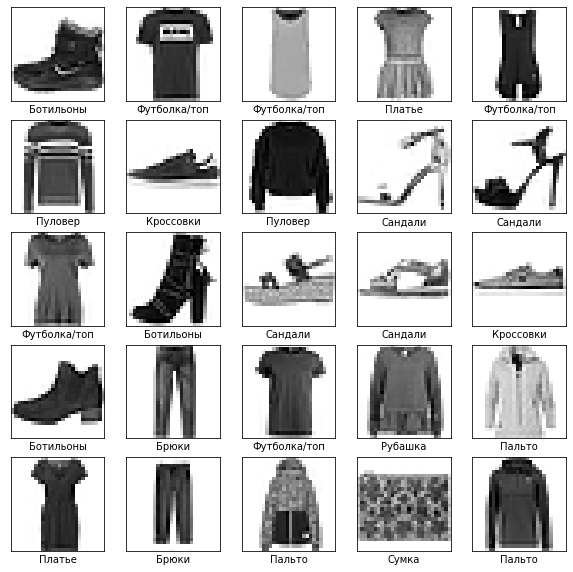

In [3]:
class_names = ["Футболка/топ", "Брюки", "Пуловер", "Платье", "Пальто", "Сандали", "Рубашка", "Кроссовки", "Сумка", "Ботильоны"]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [4]:
layers = tf.keras.layers
to_categorical = tf.keras.utils.to_categorical

### Подобрать числа нейронов в слое (для 2-хслойной сети)

In [5]:
neural_results = {
    'Neurals': [],
    'Accuracy_train': [],
    'Accuracy_test': []
}

In [6]:
n = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

for i in n:
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=[28, 28, 1]))
    model.add(layers.Dense(i, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    hh = model.fit(x_train, to_categorical(y_train), epochs=10, batch_size=128, validation_split=0.2, verbose = 0)
    
    accuracy_tr = round((hh.history['accuracy'][-1]), 4)
    
    loss, accuracy_t = model.evaluate(x_test, to_categorical(y_test), verbose = 0)
    
    neural_results['Neurals'].append(i)
    neural_results['Accuracy_train'].append(accuracy_tr)
    neural_results['Accuracy_test'].append(accuracy_t)
    
pd.DataFrame(data=neural_results)

,Neurals,Accuracy_train,Accuracy_test
0,8,0.8414,0.8257
1,16,0.8707,0.8507
2,32,0.8837,0.8602
3,64,0.8920,0.8704
4,128,0.9006,0.8793
5,256,0.9087,0.8723
6,512,0.9135,0.8803
7,1024,0.9149,0.8840
8,2048,0.9180,0.8828
9,4096,0.9184,0.8894


* Для этой задачи достаточно 512 нейронов.

##### Дальше по коду буду использовать функцию потерь 'sparse_categorical_crossentropy'. Потому что это позволит не переводить классы в категориальнвый вид, так как эта функция использует целочисленные значения (индекс класса) - Это я так понял из документации keras.

### Число слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров)

In [7]:
layers_results = {
    'Layers': [],
    'Accuracy_train': [],
    'Accuracy_test': []
}

In [8]:
l = [1, 2, 4, 9]
i = 0
for i in range(len(l)):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=[28, 28, 1]))
    for k in range(l[i]):
        model.add(layers.Dense((512 // l[i]) - k, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    hh = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2, verbose = 0)

    accuracy_tr = round((hh.history['accuracy'][-1]), 4)

    loss, accuracy_t = model.evaluate(x_test, y_test, verbose = 0)

    layers_results['Layers'].append(l[i]+1)
    layers_results['Accuracy_train'].append(accuracy_tr)
    layers_results['Accuracy_test'].append(accuracy_t)
    
    i += 1

pd.DataFrame(data=layers_results)

,Layers,Accuracy_train,Accuracy_test
0,2,0.9120,0.8830
1,3,0.9152,0.8813
2,5,0.9072,0.8789
3,10,0.8972,0.8660


* 2-хслойная сеть показало лучший результат

### Проверить работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1

In [9]:
optimizer_results = {
    'Optimizers': [],
    'Accuracy_train': [],
    'Accuracy_test': []
}

In [10]:
for i_optim in [tf.keras.optimizers.RMSprop(),tf.keras.optimizers.SGD( ),tf.keras.optimizers.Adam( ),tf.keras.optimizers.Nadam( )]:
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=[28, 28, 1]))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(
        optimizer=i_optim,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    hh = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2, verbose = 0)
    
    accuracy_tr = round((hh.history['accuracy'][-1]), 4)
    
    loss, accuracy_t = model.evaluate(x_test, y_test, verbose = 0)

    optimizer_results['Optimizers'].append(model.optimizer.get_config()['name'])
    optimizer_results['Accuracy_train'].append(accuracy_tr)
    optimizer_results['Accuracy_test'].append(accuracy_t)

pd.DataFrame(data=optimizer_results)                   

,Optimizers,Accuracy_train,Accuracy_test
0,RMSprop,0.9126,0.8817
1,SGD,0.8436,0.8326
2,Adam,0.9142,0.8870
3,Nadam,0.9200,0.8752


* Лучший оптимизатор для этой задачи - 'Nadam'

### Постоить матрицу ошибок.

In [11]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [12]:
y_pred = np.argmax(probability_model.predict(x_test), axis=1)

In [13]:
CM = confusion_matrix(y_test,y_pred)
print(CM)

[[812   7   8  35   8   0 126   0   4   0]
 [  1 975   0  19   2   0   2   0   1   0]
 [ 16   1 635  19 165   0 164   0   0   0]
 [ 11  10   6 920  18   0  31   0   4   0]
 [  0   0  33  58 819   0  90   0   0   0]
 [  0   0   0   1   0 950   0  18   2  29]
 [ 93   1  35  36  61   0 767   0   7   0]
 [  0   0   0   0   0  17   0 931   0  52]
 [  8   0   2   6   8   3   5   3 965   0]
 [  0   0   0   0   0   3   1  18   0 978]]


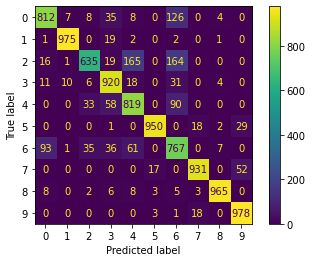

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=np.arange(10))

disp.plot( values_format ='.3g')
plt.show()

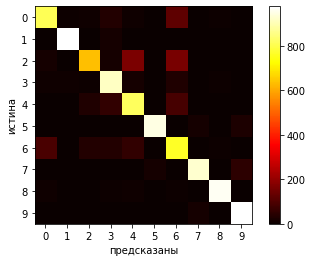

In [15]:
plt.imshow(CM, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.yticks(ticks=np.arange(10))
plt.xticks(ticks=np.arange(10))
plt.xlabel('предсказаны')
plt.ylabel('истина')
plt.show()